# Aneris showcase

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import numpy as np  # Used for creating rating / indicator functions
import pyam  # Useful for storing climate / energy scenario data
import pandas as pd
from pandas import DataFrame
pd.DataFrame.iteritems = pd.DataFrame.items

from pandas_indexing import *

import data_shepherd as ds
from data_shepherd.utils import convert_unit
import data_shepherd.energy_forms 

# from data_shepherd.siamese_io import check_historic_calibration, plot_historic_calibration
import datatoolbox as dt

from aneris import Harmonizer

import pycountry

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns


ca_colors = ['#95AD28','#2C8090','#F0280E','#F0CF1C','#1478B0','#59C954','#059E73','#945EB0','#383836','#828282','#C2C2C2']
ca_colors = sns.color_palette(ca_colors)
ca_colors

from matplotlib import rcParams
# rcParams['font.sans-serif'] = ['Lato']

sns.set_palette(ca_colors)


import logging
pyam.logger.setLevel(logging.ERROR)
logger = logging.getLogger()
logger.setLevel("WARNING")

<IPython.core.display.Javascript object>

## Define functions and region groupings
We define a range of helper functions first, which can save us time later on

In [3]:
def elec(tech=None):
    if tech==None:
        return "Secondary Energy|Electricity"
    else:
        return f"Secondary Energy|Electricity|{tech}"

In [4]:
def iso_to_name(iso):
    if pycountry.countries.get(alpha_3=iso) is None:
        return iso
    else:
        return  pycountry.countries.get(alpha_3=iso).name


In [5]:
region_map = {
    'R10AFRICA':'SSA',
    'R10CHINA+':'CHA',
    'R10EUROPE':'EUR',
    'R10LATIN_AM':'LAM',
    'R10MIDDLE_EAST':'MEA',
    'R10REF_ECON':'REF',
    'R10REST_ASIA':'OAS',
    'R10NORTH_AM':'USA',
    'R10PAC_OECD':'JPN',
    'R10INDIA+':'IND',
    'R10ROWO':'ROWO',
    'World':'World'}


## Load and process data

### Historical data
Here we load historical data for comparison to our IAMs. This is currently partial and needs completing

In [6]:
logger.setLevel('ERROR')
hist_data = ds.energy_forms.get_historic_iea_web(source='IEA_WEB_DETAILED_2024')
logger.setLevel('WARNING')


In [7]:

# Regroup all the rescaled countries within their regions
remind_map = ds.utils.RegionMapping.from_model('R10_REMIND_2.1')
remind_map

RegionMapping(model_name='R10_REMIND_2.1', iso_to_region=ISO
ABW       R10LATIN_AM
AFG      R10REST_ASIA
AGO         R10AFRICA
AIA       R10LATIN_AM
ALA         R10EUROPE
            ...      
WSM      R10REST_ASIA
YEM    R10MIDDLE_EAST
ZAF         R10AFRICA
ZMB         R10AFRICA
ZWE         R10AFRICA
Name: R10_REMIND_2.1.REGION, Length: 246, dtype: object, region_names={'R10LATIN_AM': 'Latin America', 'R10REST_ASIA': 'Other Asia', 'R10AFRICA': 'Africa', 'R10EUROPE': 'Europe', 'R10ROWO': 'Rest of World', 'R10MIDDLE_EAST': 'Middle East', 'R10REF_ECON': 'Reforming Economies', 'R10CHINA+': 'China+', 'R10INDIA+': 'India+', 'R10PAC_OECD': 'Pacific OECD', 'R10NORTH_AM': 'North America'})

In [11]:

# Dataset preparation
hist_data_region = hist_data.timeseries()
hist_data_region.index.names = ['model', 'scenario', 'country', 'variable', 'unit']

# Add regions
hist_data_region = hist_data_region.pix.semijoin(remind_map.index, how="left")


In [12]:
           
hist_data_region=hist_data_region.loc[~isin(region=np.nan)]

# # Groupby regions and sum (much faster than doing in pyam)
hist_data_region = pyam.IamDataFrame(
    hist_data_region
    .groupby(['model','scenario','variable','unit','region'])
    .sum())

# hist_data_region
hist_data = pyam.IamDataFrame(hist_data_region)
   
# Drop 2023 data as it is currently missing quite a few countries
hist_data.filter(year=2023,keep=False,inplace=True)

hist_data = (hist_data
             .rename(region=region_map)
             .filter(region=['SSA','CHA','EUR','IND','LAM','MEA','USA','JPN','REF','OAS','ROWO'])
            )

for var in hist_data.variable:
    hist_data.aggregate_region(
        var,
        'World',
        append=True)

### Bespoke scenarios
These are the new scenarios that PIK are producing

In [13]:
BOX_PROJECT_PATH = (
    "Climate Policy Team/02 - Projects/IKEA NDC 1.5° Pathways 23-25 - phase II/"
    "2 - Work Packages/WP1 - Updating global 1.5°C Pathways/1 - PIK/"
    "Scenario Data"
)

BOX_MOUNT_PATH = Path("~/Library/CloudStorage/Box-Box").expanduser()
if not BOX_MOUNT_PATH.is_dir():
    BOX_MOUNT_PATH = Path("~/Box").expanduser()

box_path: os.PathLike = BOX_MOUNT_PATH / BOX_PROJECT_PATH

In [14]:

jan_latest_version = "Scenarios_25012025/NAVIGATE_REMIND__2025-01-25_10.11.51.xlsx"

In [15]:
key_variables = ['Emissions|CO2*','Emissions|CH4','Emissions|N2O','Emissions|F-Gases','Emissions|Kyoto Gases',
                 'Secondary Energy|Electricity**','Final Energy**','Primary Energy**']

In [16]:

bespoke_idf = pyam.IamDataFrame(box_path / jan_latest_version)
bespoke_idf = bespoke_idf.filter(scenario='ikea590*')

# For comparison with the AR6 pathways, we focus on the ROWO region (rest of world), which is the sum of CAZ and NEU    
for variable in key_variables:
    bespoke_idf.aggregate_region(
        variable,
        'ROWO',
        ['CAZ','NEU'],
        append=True)

bespoke_idf.rename(variable={elec('Other'):elec('Hydrogen')},inplace=True)

bespoke_idf.filter(region=['CAZ','NEU'],keep=False,inplace=True)


### Harmonise data

In [17]:
hist_data_for_harm = (
    hist_data
    .convert_unit('EJ / yr','EJ/yr')
    .convert_unit('TWh / yr','EJ/yr')
)

Add zero historical data in where needed

In [18]:
zero_indices = (
    bespoke_idf
    .filter(
        variable=[
            'Final Energy|Carbon Removal**',
            #TODO: Explore if more variables need to be added, and how best to add them 
            #(You need some strict matching of indices in historical and future data, and so adding
            #zero variables can sometimes create issues if it breaks the equivalence of indices)
        ],
    )
    .timeseries()
    .index
    .pix.assign(
        model=hist_data.model[0],
        scenario=hist_data.scenario[0])
    .drop_duplicates()
)

zero_hist_data = (
    pd.DataFrame(
        index=zero_indices,
        columns=hist_data_for_harm.year)
    .fillna(0)
    )

hist_data_for_harm = hist_data_for_harm.append(zero_hist_data)

Identify variables which are available for harmonisation (where there is historical data available)

In [19]:
harm_ix = (
    hist_data_for_harm.timeseries()
    .droplevel(['model','scenario'])
    .index
    .intersection(
        bespoke_idf.timeseries()
        .droplevel(['model','scenario'])
        .index)
    .pix
    .assign(model=hist_data_for_harm.model[0],scenario=hist_data_for_harm.scenario[0])
    .reorder_levels(hist_data_for_harm.timeseries().index.names)
)

In [20]:
len(harm_ix)

1016

In [21]:
# Select historical data
hist_data_for_harm = (
    hist_data_for_harm.timeseries()
    .loc[harm_ix,2010:2022]
)


#Rename data to match the model/scenario combinations in the bespoke data (need strict matching for harmonisation)
hist_data_for_harm = pd.concat([
    hist_data_for_harm.pix.assign(model=m,scenario=s)
    for m,s in bespoke_idf.index])

hist_data_for_harm.head()


2010  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2011  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2012  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2013  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2014  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2015  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon 

In [22]:
harm_ix_model = pd.concat([
    harm_ix.pix.assign(model=m,scenario=s).to_frame()
    for m,s in bespoke_idf.index]).index

harm_ix_model

MultiIndex([('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ...
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
    

In [23]:
# Select data for harmonisation

data_to_harmonise = (
    bespoke_idf
    # .filter(scenario='dec_version_570')
    .timeseries()
    .loc[harm_ix_model]
)

#Add the years contained in historical data and interpolate to fill in nas
data_to_harmonise = (
    data_to_harmonise.T
    .reindex(set(hist_data_for_harm.columns).union(set(data_to_harmonise.columns)))
    .sort_index()
    .interpolate()
    .T
   )

data_to_harmonise.head()
    


2005  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2010  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2011  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2012  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2013  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr   0.0   

                                                                                                     2014  \
model      scenario                 region variable                                           unit          
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon 

In [24]:
harmonizer = Harmonizer(
    data_to_harmonise,
    hist_data_for_harm,
    harm_idx=["model","scenario","variable","region","unit"],
)

Run the harmonisation

In [25]:
logger.setLevel('ERROR')
harmonized = harmonizer.harmonize(2022)
methods = harmonizer.methods_used
if isinstance(methods, DataFrame):
    methods = methods["method"]

harmonized = harmonized.pix.assign(method=methods)

/Users/neilg/repos/aneris/src/aneris/methods.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  return np.abs(np.std(x) / np.mean(x))
INFO:root:No data in the model dataframe for ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'CHA', 'Final Energy', 'EJ/yr'), dH_abs_thresh not calculated
INFO:root:No data in the model dataframe for ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'CHA', 'Final Energy', 'EJ/yr'), dH_abs_thresh not calculated
INFO:root:No data in the model dataframe for ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'CHA', 'Final Energy', 'EJ/yr'), dH_abs_thresh not calculated
INFO:root:No data in the model dataframe for ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'CHA', 'Final Energy', 'EJ/yr'), dH_abs_thresh not calculated
INFO:root:No data in the model dataframe for ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'CHA', '', 'EJ/yr'), dH_abs_thresh not calculated
INFO:root:No data in the model dataframe for ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'CHA', 'Secondary En

In [26]:
methods.value_counts()

method
reduce_ratio_2080        468
hist_zero                389
constant_ratio            85
reduce_ratio_2150_cov     45
reduce_offset_2030        26
constant_offset            3
Name: count, dtype: int64

In [27]:
# Checking that no energy results are harmonised to negative values
harmonized[harmonized.lt(0).any(axis=1)]
# uniquelevel(harmonized[harmonized.lt(0).any(axis=1)],'method')

Empty DataFrame
Columns: [2022, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2070, 2080, 2090, 2100]
Index: []

In [28]:
# Add historical data for 2010 to 2021 into the data frame
harmonized = (harmonized
        .reindex(set(hist_data_for_harm.columns).union(set(harmonized.columns)),axis=1)
        .sort_index(axis=1)
       )

# Add the historical data 
harmonized.loc[:,:2021] = (
    hist_data_for_harm.loc[harm_ix_model,:2021]
)

harmonized.head()

2010  \
model      scenario                 region variable                                           unit  method            
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr hist_zero   0.0   

                                                                                                               2011  \
model      scenario                 region variable                                           unit  method            
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr hist_zero   0.0   

                                                                                                               2012  \
model      scenario                 region variable                                           unit  method            
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr hist_zero   0.0   

                                                                                                               2013  \
model      scenario                 region variable                                           unit  method            
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Enhance... EJ/yr hist_zero   0.0   

                                                                                                               2014  \
model      scenario                 region variable                                           unit  method            
REMIND 3.4 ikea590_demand_b70_nonuc CHA    Final Energy|Carbon Removal                        EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Direct Air Capture     EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity            EJ/yr hist_zero   0.0   
                                           Final Energy|Carbon Removal|Electricity|Direct ... EJ/yr hist_zero   0.0   
                                           Final Energy|Carbo

Plot the results of harmonisation for some variables

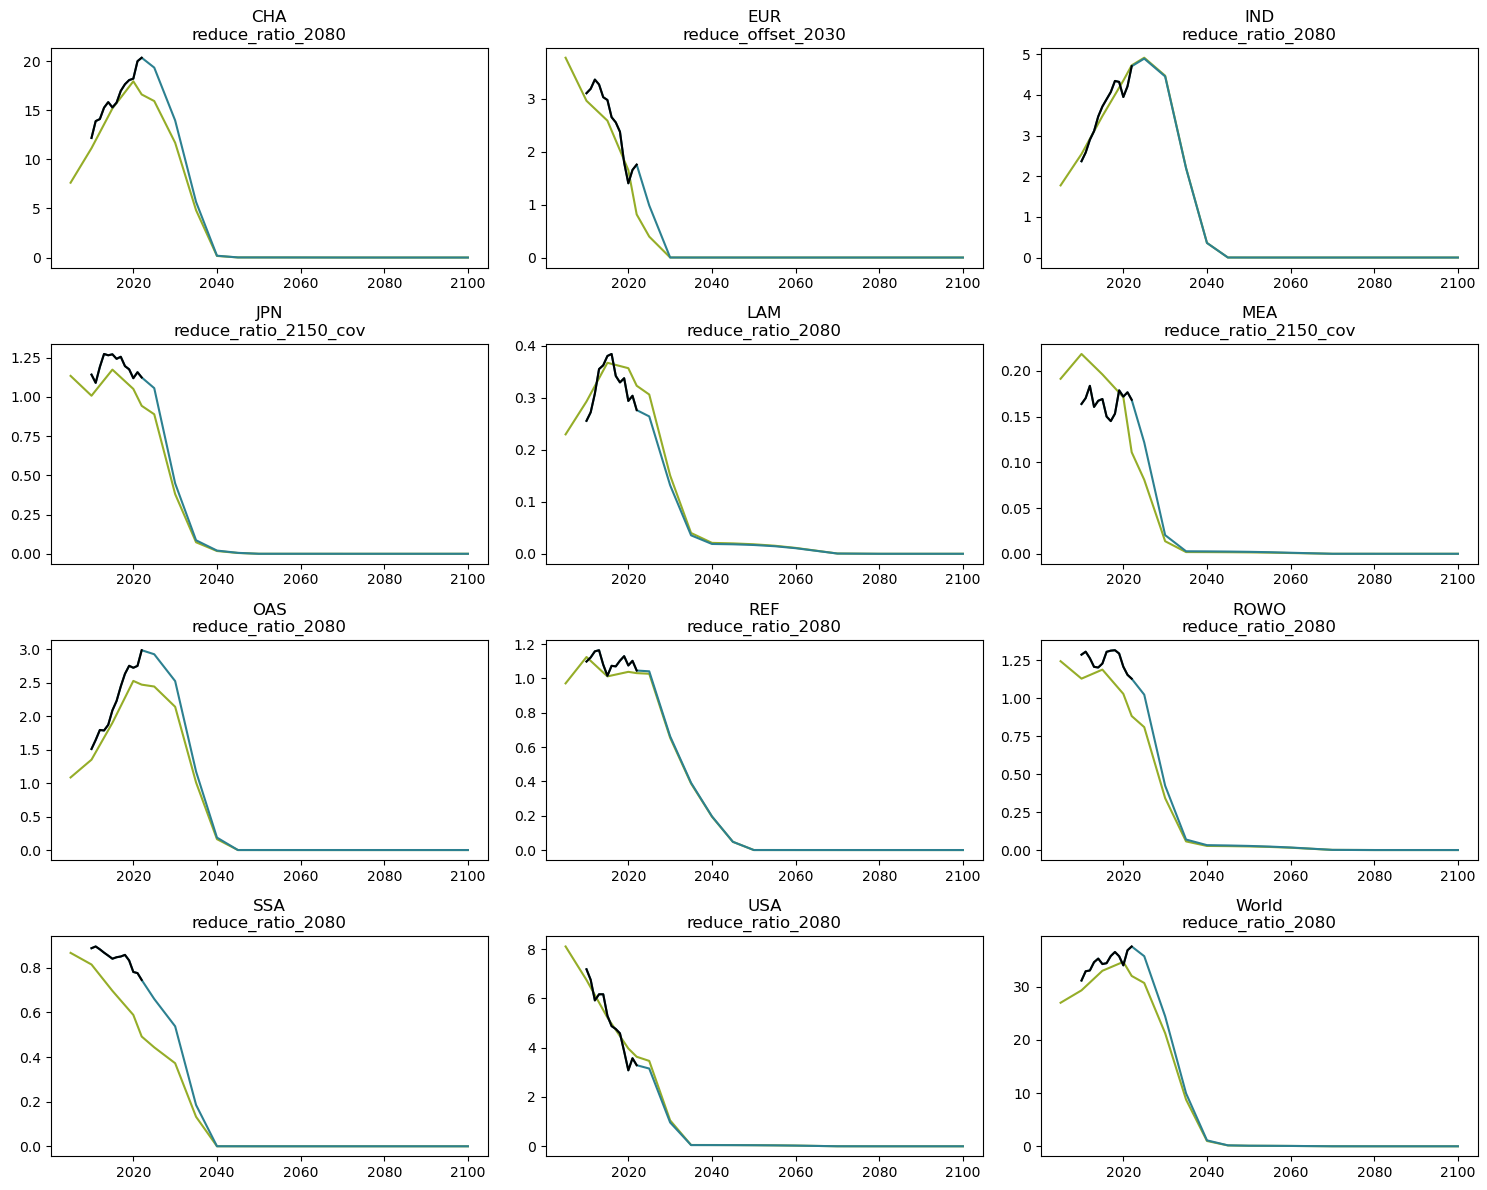

In [29]:
v = elec('Coal')
regions = harmonized.pix.unique('region')

f, axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12))
axr = axes.ravel()

for count, ax in enumerate(axr):
    data_to_harmonise.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    harmonized.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    hist_data_for_harm.loc[isin(region=regions[count],variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
    axr[count].set_title(regions[count] + '\n' + methods.loc[isin(region=regions[count],variable=v)].unique()[0])
    
plt.tight_layout()

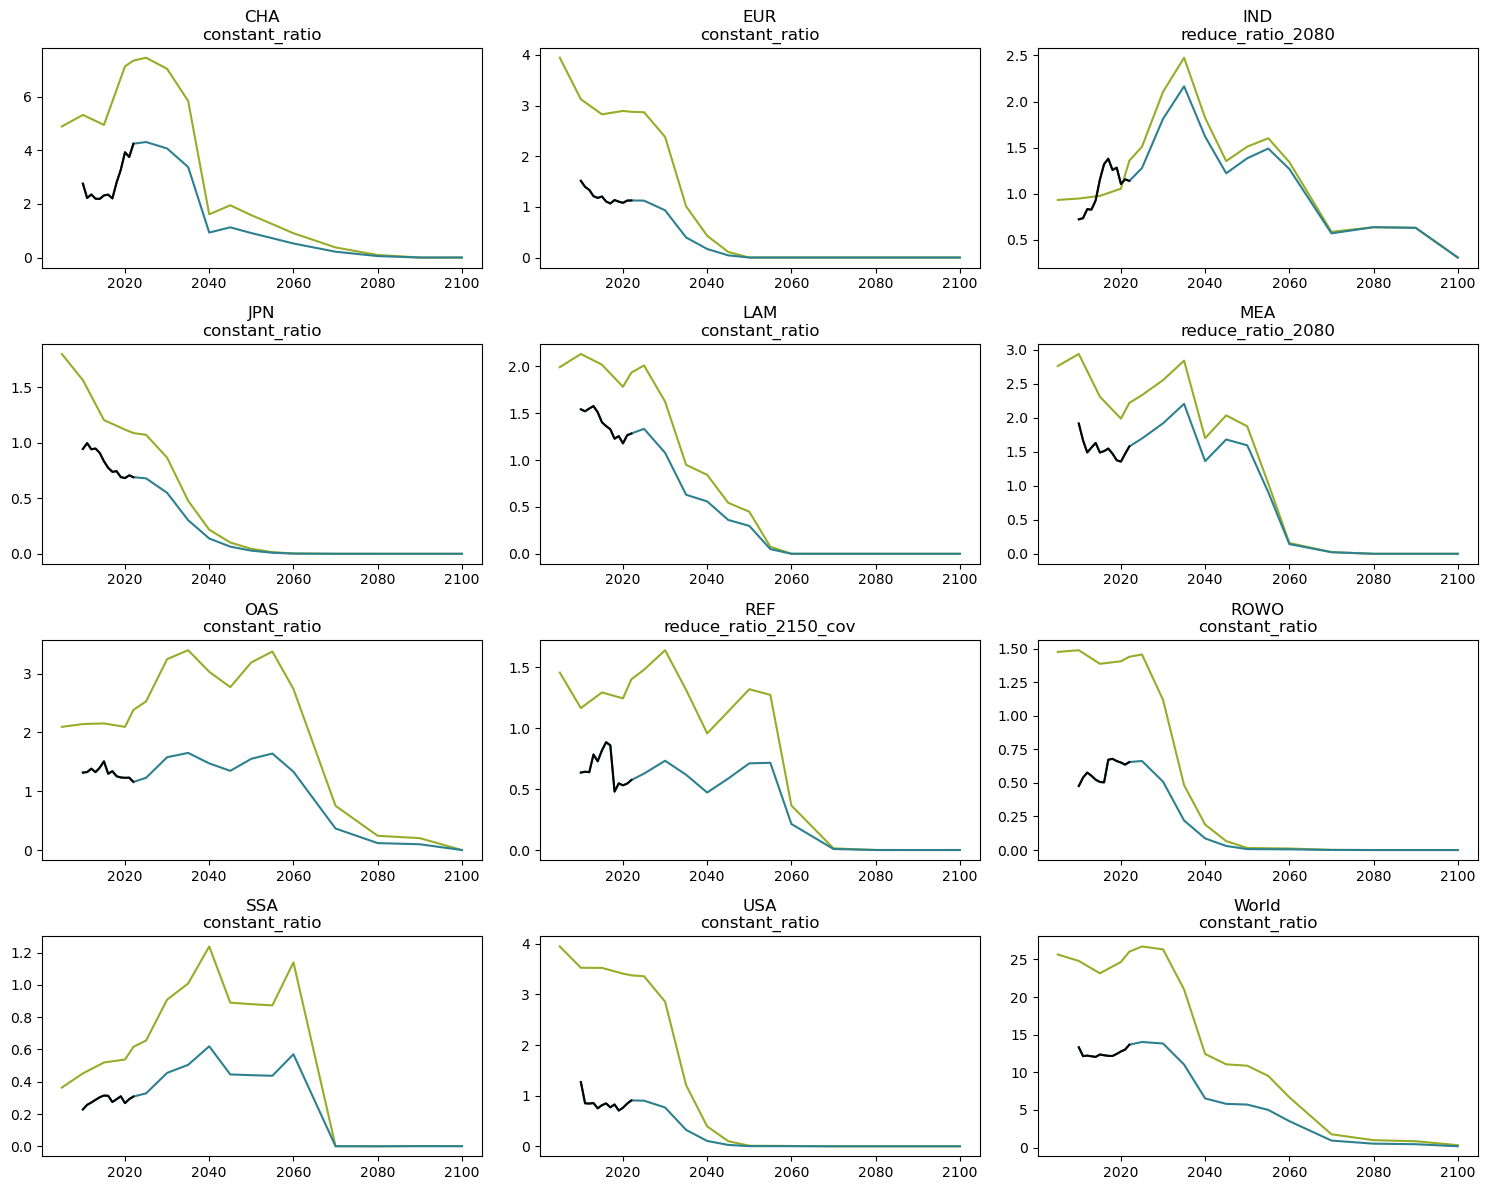

In [30]:
v = 'Final Energy|Industry|Liquids|Fossil'
regions = harmonized.pix.unique('region')

f, axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12))
axr = axes.ravel()

for count, ax in enumerate(axr):
    data_to_harmonise.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    harmonized.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    hist_data_for_harm.loc[isin(region=regions[count],variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
    axr[count].set_title(regions[count] + '\n' + methods.loc[isin(region=regions[count],variable=v)].unique()[0])
    
plt.tight_layout()

In [31]:
v = 'Final Energy|Transportation|Electricity'
regions = harmonized.pix.unique('region')

f, axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12))
axr = axes.ravel()

for count, ax in enumerate(axr):
    data_to_harmonise.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    harmonized.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    hist_data_for_harm.loc[isin(region=regions[count],variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
    axr[count].set_title(regions[count] + '\n' + methods.loc[isin(region=regions[count],variable=v)].unique()[0])
    
plt.tight_layout()

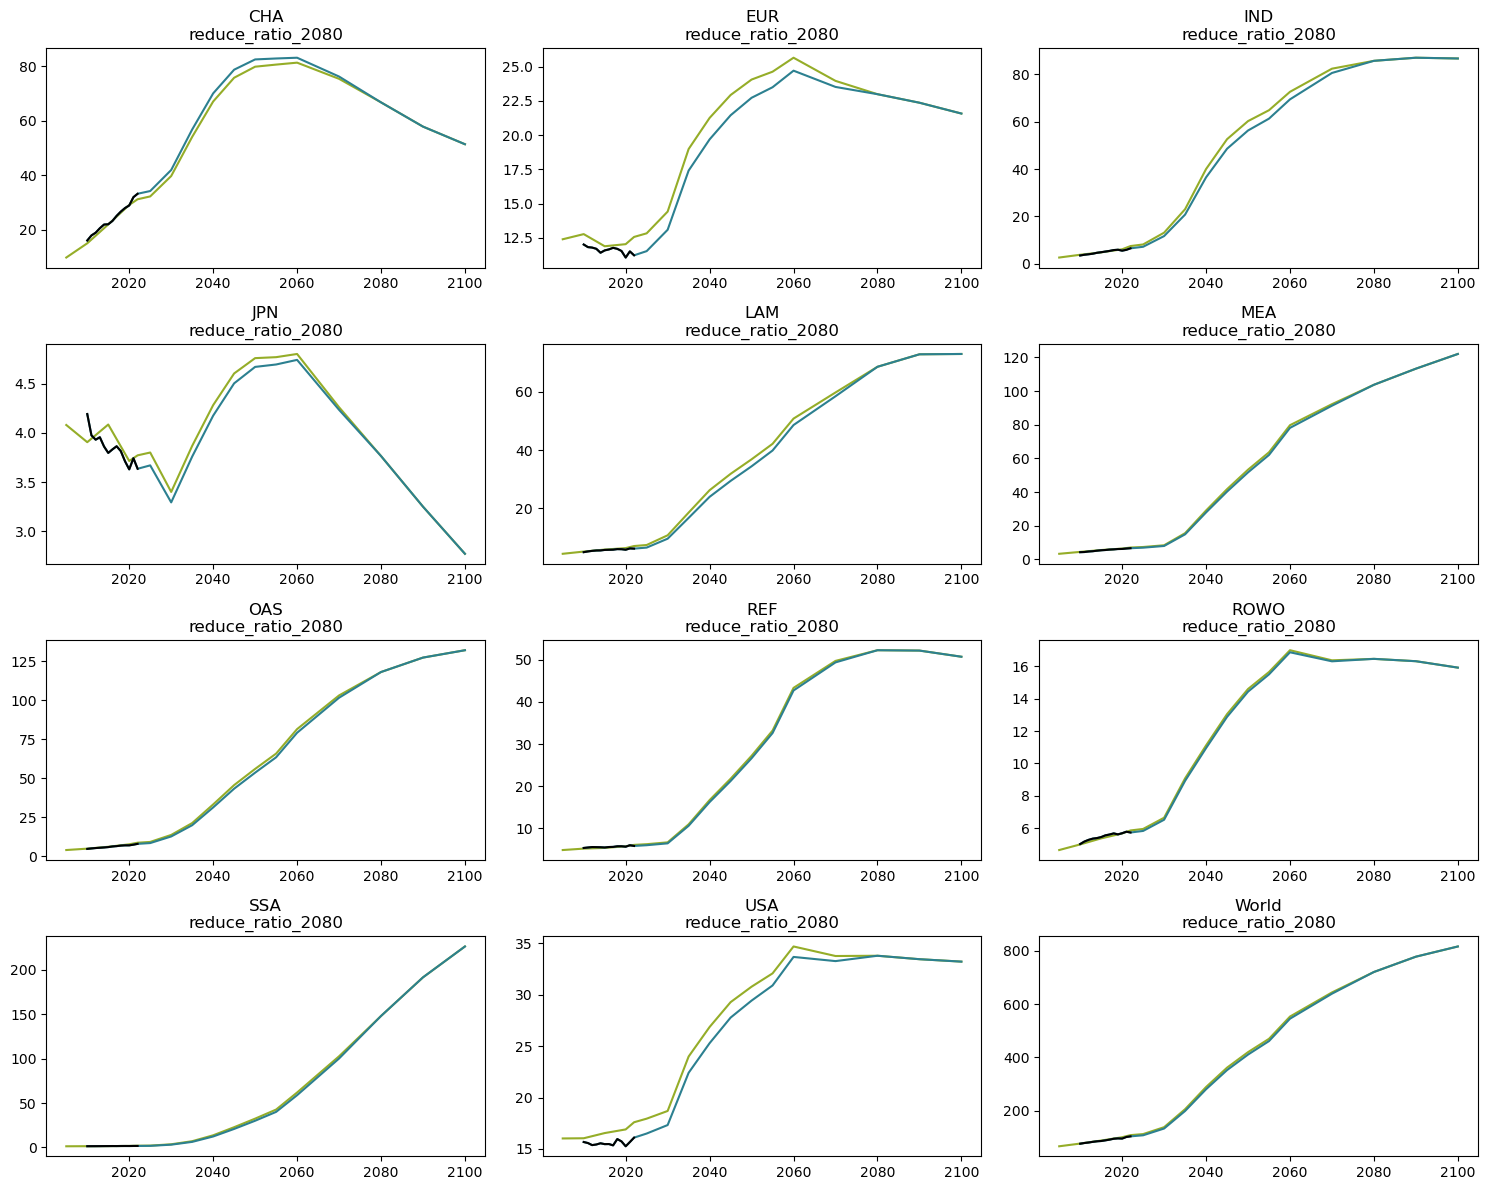

In [32]:
v = elec()
regions = harmonized.pix.unique('region')

f, axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12))
axr = axes.ravel()

for count, ax in enumerate(axr):
    data_to_harmonise.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    harmonized.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    hist_data_for_harm.loc[isin(region=regions[count],variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
    axr[count].set_title(regions[count] + '\n' + methods.loc[isin(region=regions[count],variable=v)].unique()[0])
    
plt.tight_layout()

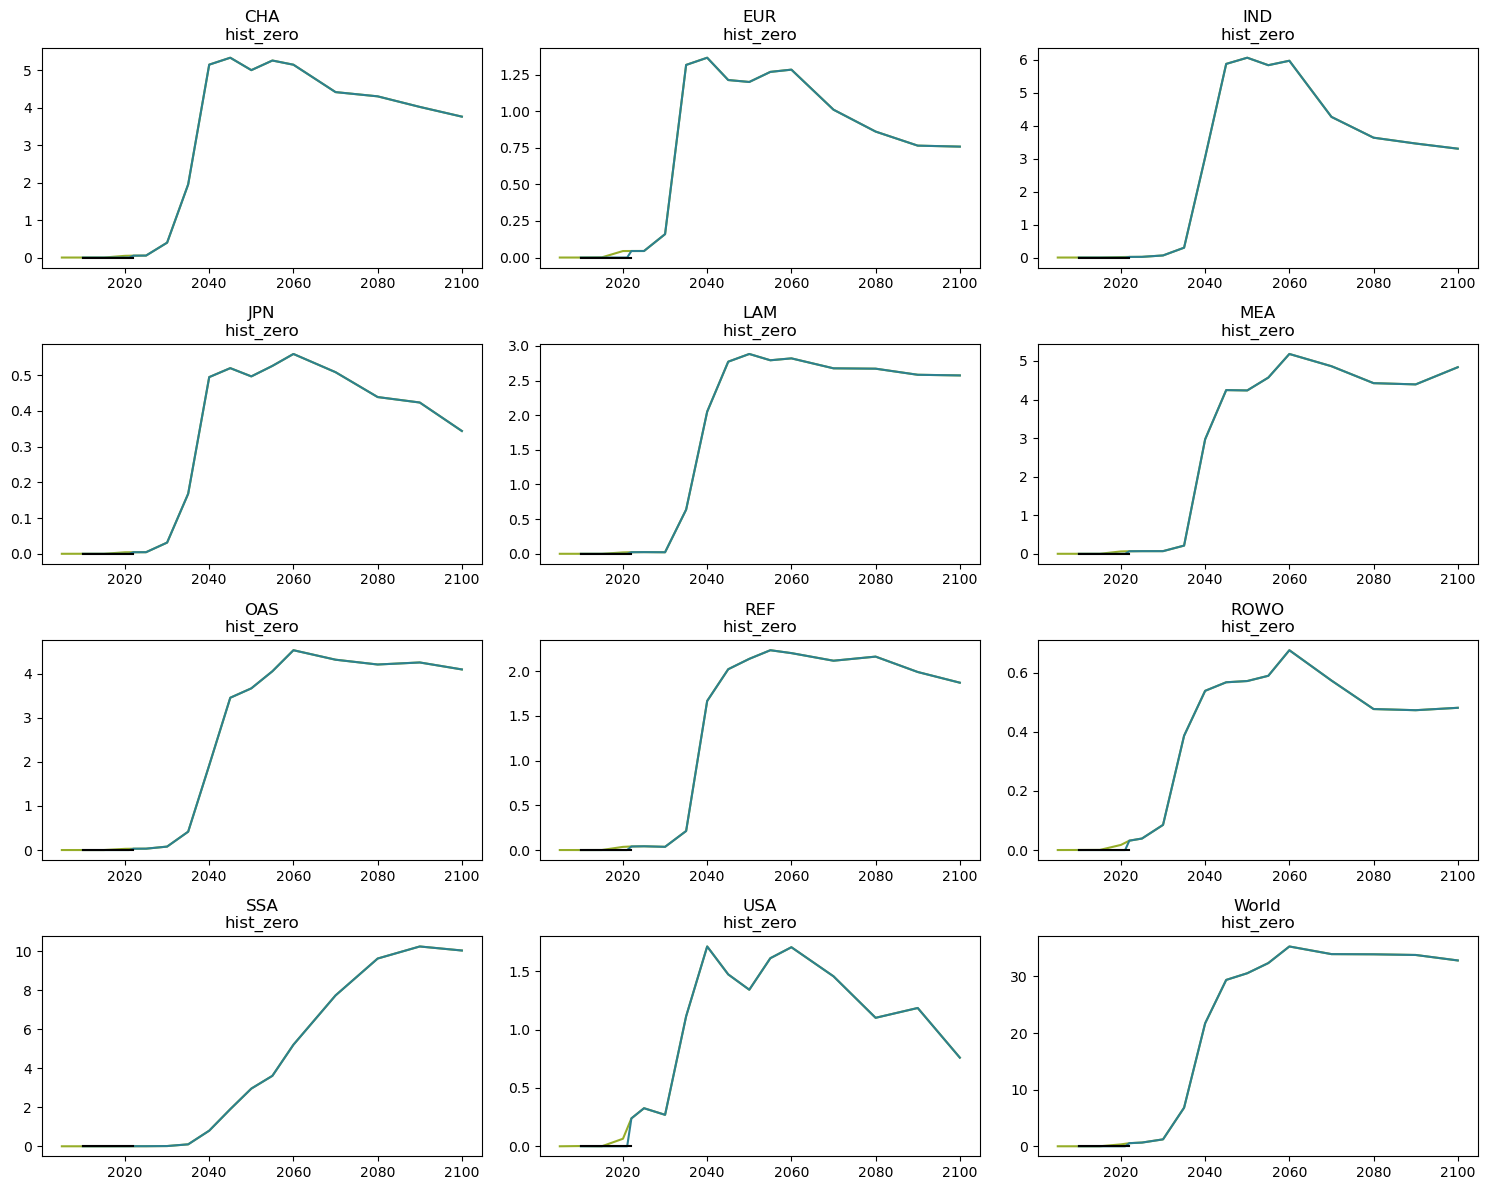

In [33]:
v = 'Final Energy|Industry|Hydrogen'
regions = harmonized.pix.unique('region')

f, axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12))
axr = axes.ravel()

for count, ax in enumerate(axr):
    data_to_harmonise.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    harmonized.loc[ismatch(region=regions[count],variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
    hist_data_for_harm.loc[isin(region=regions[count],variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
    axr[count].set_title(regions[count] + '\n' + methods.loc[isin(region=regions[count],variable=v)].unique()[0])
    
plt.tight_layout()

Add some possible overrides to the system

In [34]:
overrides = [
    {"region": "EUR", "variable":elec('Non-Biomass Renewables'),"method": "reduce_ratio_2080"},    
    {"region": "USA", "variable":"Final Energy|Transportation|Electricity","method": "reduce_offset_2080"},
    {"region": "LAM", "variable":"Final Energy|Transportation|Electricity","method": "reduce_offset_2080"}
]
overrides = pd.DataFrame(overrides).set_index(["region","variable"])["method"]
overrides

region  variable                                           
EUR     Secondary Energy|Electricity|Non-Biomass Renewables     reduce_ratio_2080
USA     Final Energy|Transportation|Electricity                reduce_offset_2080
LAM     Final Energy|Transportation|Electricity                reduce_offset_2080
Name: method, dtype: object

In [35]:
logger.setLevel('ERROR')
harmonized_overrides = harmonizer.harmonize(2022,overrides=overrides)
methods_overrides = harmonizer.methods_used
if isinstance(methods_overrides, DataFrame):
    methods_overrides = methods_overrides["method"]

harmonized_overrides = harmonized_overrides.pix.assign(method=methods_overrides)

/Users/neilg/repos/aneris/src/aneris/methods.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  return np.abs(np.std(x) / np.mean(x))


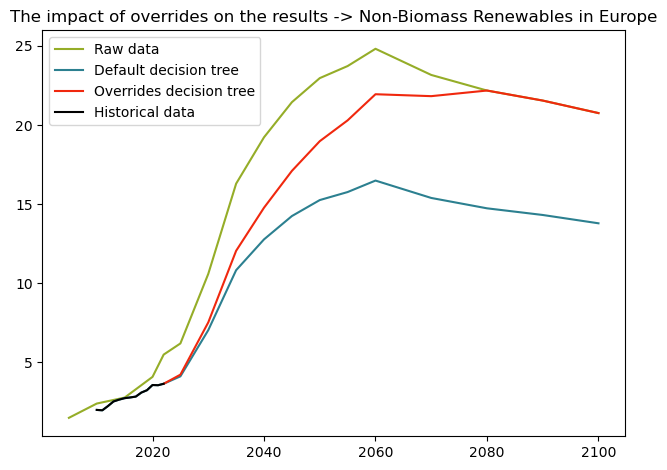

In [36]:
v = elec('Non-Biomass Renewables')

f, ax = plt.subplots()
data_to_harmonise.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized_overrides.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
hist_data_for_harm.loc[isin(region='EUR',variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
ax.legend(['Raw data','Default decision tree','Overrides decision tree','Historical data'])
ax.set_title('The impact of overrides on the results -> Non-Biomass Renewables in Europe')
    
plt.tight_layout()

In [37]:
v = 'Final Energy|Transportation|Electricity'

f, ax = plt.subplots()
data_to_harmonise.loc[ismatch(region='USA',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized.loc[ismatch(region='USA',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized_overrides.loc[ismatch(region='USA',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
hist_data_for_harm.loc[isin(region='USA',variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
ax.legend(['Raw data','Default decision tree','Overrides decision tree','Historical data'])
ax.set_title('The impact of overrides on the results -> Transport electrification in USA')
    
plt.tight_layout()

In [38]:


fast_overrides = [
    {"region": "EUR", "variable":elec('Non-Biomass Renewables'),"method": "reduce_ratio_2050"},    
]
fast_overrides = pd.DataFrame(fast_overrides).set_index(["region","variable"])["method"]

logger.setLevel('ERROR')
harmonized_fast = harmonizer.harmonize(2022,overrides=fast_overrides)


/Users/neilg/repos/aneris/src/aneris/methods.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  return np.abs(np.std(x) / np.mean(x))


In [39]:
v = elec('Non-Biomass Renewables')

f, ax = plt.subplots()
data_to_harmonise.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized_overrides.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized_fast.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
hist_data_for_harm.loc[isin(region='EUR',variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
ax.legend(['Raw data','Default methods','2080 convergence','2050 convergence','Historical data'])
ax.set_title('The impact of faster harmonisation on the results')
    
plt.tight_layout()

In [40]:


method_overrides = [
    {"region": "EUR", "variable":elec('Non-Biomass Renewables'),"method": "reduce_offset_2080"},    
]
method_overrides = pd.DataFrame(method_overrides).set_index(["region","variable"])["method"]

logger.setLevel('ERROR')
harmonized_method = harmonizer.harmonize(2022,overrides=method_overrides)


/Users/neilg/repos/aneris/src/aneris/methods.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  return np.abs(np.std(x) / np.mean(x))


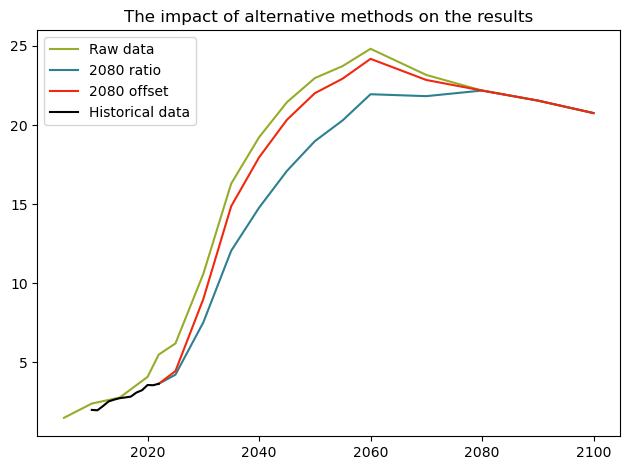

In [41]:
v = elec('Non-Biomass Renewables')

f, ax = plt.subplots()
data_to_harmonise.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized_overrides.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
harmonized_method.loc[ismatch(region='EUR',variable=v,scenario='**590**')].T.plot(ax=ax,legend=False)
hist_data_for_harm.loc[isin(region='EUR',variable=v)].T.plot(ax=ax,legend=False,color='k',lw=1.5)
ax.legend(['Raw data','2080 ratio','2080 offset','Historical data'])
ax.set_title('The impact of alternative methods on the results')
    
plt.tight_layout()

### Check for aggregation errors and solve

In [42]:
logger.setLevel('INFO')

data = []

for query in uniquelevel(harmonized,['model','scenario']):
    data.append(
        ds.energy_forms.get_projection(
            sectors=[
                'Primary Energy',
                 'Final Energy|Industry',
                 'Final Energy|Transportation',
                 'Final Energy|Residential and Commercial',
                 'Secondary Energy|Electricity'
            ],
            df=harmonized.loc[isin(model=query[0],scenario=query[1])],
            check_aggregation_thresholds = [0.5,0.8],
            check_for_dataclass_dictionaries=False,
            model=query[0],
            scenario=query[1],
            source='test',
            dont_split=['Final Energy|Transportation|Gases'])
    )
    logger.setLevel('WARNING')

harmonized_agg = pyam.concat(data)

                                               variable  components       abs       rel  total*0.5
region variable                    unit  year                                                     
LAM    Final Energy|Transportation EJ/yr 2050  9.728011    4.804984  4.923027  0.506067   2.525111


In [43]:
logger.setLevel('INFO')

data = []

for query in uniquelevel(harmonized,['model','scenario']):
    data.append(
        ds.energy_forms.get_projection(
            sectors=[
                'Primary Energy',
                 'Final Energy|Industry',
                 'Final Energy|Transportation',
                 'Final Energy|Residential and Commercial',
                 'Secondary Energy|Electricity'
            ],
            df=harmonized_overrides.loc[isin(model=query[0],scenario=query[1])],
            check_aggregation_thresholds = [0.5,0.8],
            check_for_dataclass_dictionaries=False,
            model=query[0],
            scenario=query[1],
            source='test',
            dont_split=['Final Energy|Transportation|Gases'])
    )
    logger.setLevel('WARNING')

harmonized_overrides_agg = pyam.concat(data)

In [44]:
ix_order = ['model','scenario','region','variable','unit']

In [45]:
harmonized_agg.filter(region='World',keep=False,inplace=True)

harmonized_agg.append(
    harmonized_agg.timeseries()
    .groupby(['model','scenario','variable','unit'])
    .sum()
    .pix.assign(region='World')
    .reorder_levels(ix_order),
    inplace=True
)

In [46]:
harmonized_overrides_agg.filter(region='World',keep=False,inplace=True)

harmonized_overrides_agg.append(
    harmonized_overrides_agg.timeseries()
    .groupby(['model','scenario','variable','unit'])
    .sum()
    .pix.assign(region='World')
    .reorder_levels(ix_order),
    inplace=True
)

### Blend in harmonised data

In [47]:
keep_index = (
    hist_data_for_harm
    .droplevel(['model','scenario'])
    .index
    .intersection(
        harmonized_agg.timeseries()
        .droplevel(['model','scenario'])
        .index)
    .pix
    .assign(model='REMIND 3.4',scenario='ikea590_demand_b70_nonuc')
    .reorder_levels(hist_data_for_harm.index.names)
)

keep_index

MultiIndex([('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc',   'CHA', ...),
            ...
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
            ('REMIND 3.4', 'ikea590_demand_b70_nonuc', 'World', ...),
    

In [48]:
harmonized_agg = harmonized_agg.timeseries().loc[keep_index]
harmonized_overrides_agg = harmonized_overrides_agg.timeseries().loc[keep_index]

In [49]:
harmonized_data = pd.concat([
    bespoke_idf.timeseries().drop(harmonized_agg.index),
    harmonized_agg
])

harmonized_data = pyam.IamDataFrame(harmonized_data)
harmonized_data.interpolate(time=2022,inplace=True)

In [50]:
harmonized_data_overrides = pd.concat([
    bespoke_idf.timeseries().drop(harmonized_overrides_agg.index),
    harmonized_overrides_agg
])

harmonized_data_overrides = pyam.IamDataFrame(harmonized_data_overrides)
harmonized_data_overrides.interpolate(time=2022,inplace=True)

### Look at impact of harmonisation on cross-sectoral consistency

In [51]:
fe_elec_vars = [
    'Final Energy|Industry|Electricity',
    'Final Energy|Transportation|Electricity',
    'Final Energy|Residential and Commercial|Electricity',
    'Final Energy|Carbon Removal|Electricity'
]

harmonized_data.filter(variable='Final Energy|Electricity',keep=False,inplace=True)
harmonized_data.aggregate(
    'Final Energy|Electricity',
    fe_elec_vars,
    append=True)


harmonized_data_overrides.filter(variable='Final Energy|Electricity',keep=False,inplace=True)
harmonized_data_overrides.aggregate(
    'Final Energy|Electricity',
    fe_elec_vars,
    append=True)

In [52]:
harmonised_elec_losses = (
    harmonized_data.divide(
        'Final Energy|Electricity',
        elec(),
        'Power System T&D losses')
)

harmonised_overrides_elec_losses = (
    harmonized_data_overrides.divide(
        'Final Energy|Electricity',
        elec(),
        'Power System T&D losses')
)

unharmonised_elec_losses = (
    bespoke_idf.divide(
        'Final Energy|Electricity',
        elec(),
        'Power System T&D losses')
)

In [53]:
regions = harmonized.pix.unique('region')

f, axes = plt.subplots(ncols=3,nrows=4,figsize=(15,12))
axr = axes.ravel()

for count, ax in enumerate(axr):
    unharmonised_elec_losses.filter(region=regions[count],scenario='**590**').plot(ax=ax,legend=False)
    harmonised_elec_losses.filter(region=regions[count],scenario='**590**').plot(ax=ax,legend=False)
    if count in [1,4,10]:
        harmonised_overrides_elec_losses.filter(region=regions[count],scenario='**590**').plot(ax=ax,legend=False)
    axr[count].set_title(regions[count])
    ax.legend(['Raw data','Harmonised data','Harmonised data with overrides'])
    
    
plt.tight_layout()

<Axes: title={'center': 'model: REMIND 3.4 - scenario: ikea590_demand_b70_nonuc - region: EUR - variable: Secondary Energy|Electricity'}, xlabel='Year', ylabel='EJ/yr'>

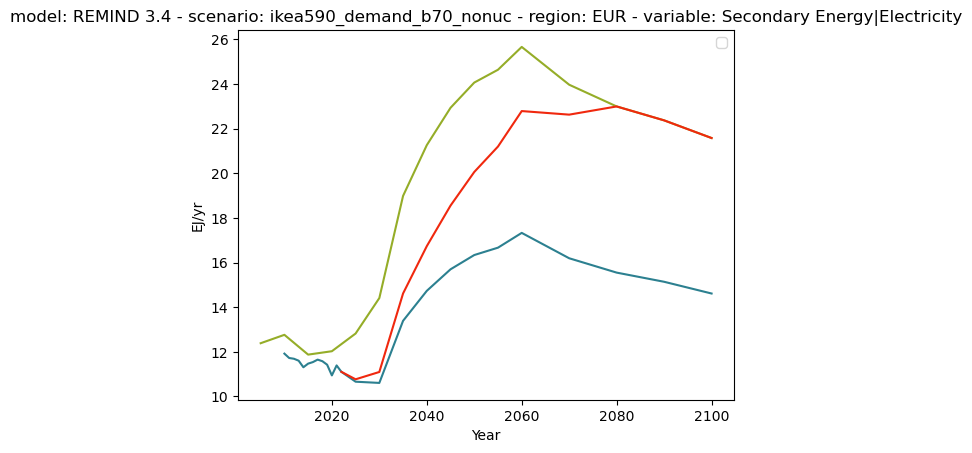

In [54]:
bespoke_idf.filter(region='EUR',variable=elec()).plot()
harmonized_data.filter(region='EUR',variable=elec()).plot(ax=plt.gca())
harmonized_data_overrides.filter(region='EUR',variable=elec()).plot(ax=plt.gca())

<Axes: title={'center': 'model: REMIND 3.4 - scenario: ikea590_demand_b70_nonuc - region: EUR - variable: Final Energy|Electricity'}, xlabel='Year', ylabel='EJ/yr'>

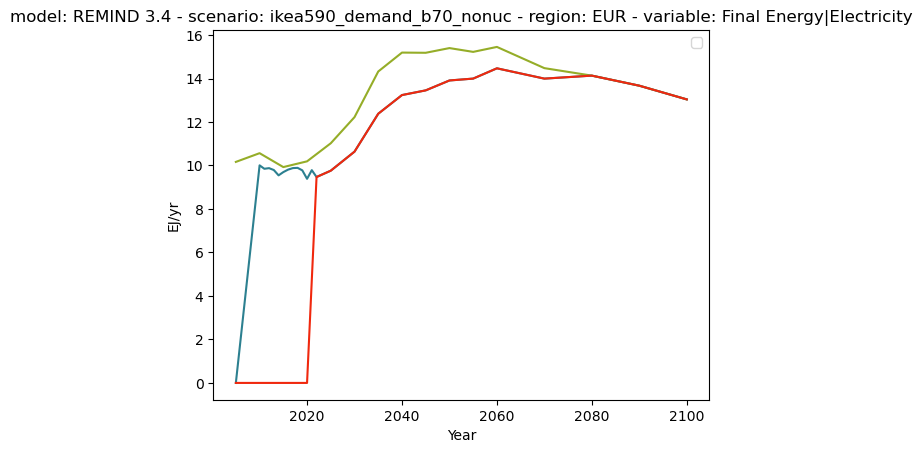

In [55]:
bespoke_idf.filter(region='EUR',variable='Final Energy|Electricity').plot()
harmonized_data.filter(region='EUR',variable='Final Energy|Electricity').plot(ax=plt.gca())
harmonized_data_overrides.filter(region='EUR',variable='Final Energy|Electricity').plot(ax=plt.gca())

### Blend data together

In [56]:
bespoke_idf = pd.concat([
    bespoke_idf.timeseries().pix.format(scenario='{scenario}_raw'),
    harmonized_agg.timeseries().pix.format(scenario='{scenario}_harm')
])

bespoke_idf = pyam.IamDataFrame(bespoke_idf)
bespoke_idf.interpolate(time=2022,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'timeseries'

In [ ]:
idf = pyam.concat([bespoke_idf,illustrative_pathways, hist_data])